In [158]:
pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import string
import collections
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

pre = pd.read_pickle('data/preevent_responses.pandas')
pre_2 = pd.read_pickle('data/preevent_responses_2.pandas')
total_pre = pd.concat([pre,pre_2])

post = pd.read_pickle('data/postevent_responses.pandas')
post_2 = pd.read_pickle('data/postevent_responses_2.pandas')
total_post = pd.concat([post,post_2])

In [ ]:
pre_expanded = pd.DataFrame()
for ind, row in total_pre.iterrows(): # this is slow and there's probably a better way
    events = row.events.split(',')
    for e in events:
        row.loc['event'] = e
        pre_expanded = pre_expanded.append(row, ignore_index=True)

matched = pd.merge(pre_expanded, total_post, on=['email', 'event'], suffixes=('_pre', '_post'))

# Pre-Survey EDA

Some questions we would like to address:
1. What is the makeup of students attending our events so far? (processing/ inferring schools based on email addresses)
2. Are students who signed up for law and medicine also attending other school events?
3. [Based on question what do you want to hear from next] What are some popular sectors that students want to hear from next?
4. How did students find out about the event?
5. Distribution of students who sign up for 1 event, 2 events, 3 events, etc

In [161]:
how_event_cols = [colname for colname in total_pre.columns if colname.startswith('how_event')]
how_event_dfs = total_pre[how_event_cols].copy(deep=True)
for x in how_event_cols:
    total_pre[x]=total_pre.pop(x)
total_pre = total_pre.drop(columns=["how",'knowledge','interest'])

## Survey descriptives

We have about 3x as many event registrations as we do event feedback responses. Using email addresses as a unique identifier, we find a total of 1063 students signing up for our events. 

In [219]:
print('Registrations: ' + str(total_pre.shape[0]) + '; unique students: ' + str(len(total_pre.email.unique())))
print('Feedback: ' + str(total_post.shape[0]) + '; unique students: ' + str(len(total_post.email.unique())))

Registrations: 2135; unique students: 1465
Feedback: 613; unique students: 469


The most popular seminars were (in order) "Medicine, Maybe?", "Healthcare Hour", and "First Forays into Finance". Seminars "Steps in Sustainability" and "Future in Finance" were also especially popular.

e1     102
e2     147
e3     235
e4     112
e5     140
e6     267
e7     292
e8     123
e9      67
e10     31
e11     72
e12     92
e13     28
e14     21
e16     72
e17    115
e18    199
e19     61
e20     23
Name: events, dtype: int64


<AxesSubplot:title={'center':'Event Sign-ups'}>

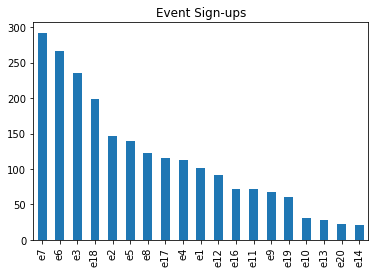

In [171]:
event_counts = total_pre.events.value_counts().loc[[f'e{i}' for i in range(1, 21) if i != 15]]
# need to double count the overlapping registrations
event_counts.loc['e10'] = sum(pre.events.value_counts().loc[[e for e in pre.events.unique() if 'e10' in e]])
event_counts.loc['e11'] = sum(pre.events.value_counts().loc[[e for e in pre.events.unique() if 'e11' in e]])
event_counts.loc['e12'] = sum(pre.events.value_counts().loc[[e for e in pre.events.unique() if 'e12' in e]])

print(event_counts)
event_counts.sort_values(ascending=False).plot(kind='bar', title='Event Sign-ups')

The distribution for the survey responses is also similar, meaning that we can generally expect about a third of event attendees to give feedback. With this 'rule of thumb', we can take a closer look at events with unusually low/high feedback responses.

e18 and e16 specifically had worryingly low feedback rates despite the high number of sign-ups. This has to be crosschecked with attendance rates and can indicate 1 of 3 things - drastically fewer participants than sign-ups, high drop-off rate in the middle of the webinar (leading to participants not reaching the feedback form stage or webinar hosts failing to display the feedback form link in time before participants dropped out of the call.

e18    28.428571
e16    24.000000
e14    10.500000
e12    10.222222
e19    10.166667
e10     6.200000
e17     5.750000
e11     5.142857
e13     4.666667
e9      4.187500
e3      4.051724
e8      3.727273
e1      3.642857
e4      3.294118
e2      3.195652
e6      3.141176
e5      2.258065
e7      2.212121
e20     1.210526
e15          NaN
dtype: float64

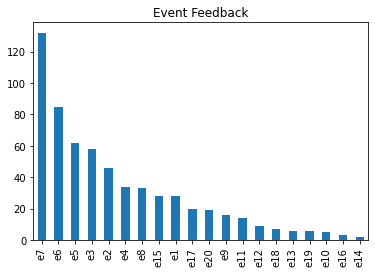

In [185]:
post_event_counts=total_post.event.value_counts()
post_event_counts.plot(kind='bar', title='Event Feedback')
(event_counts/post_event_counts).sort_values(ascending=False)

### Student demographics -- which schools are the students coming from? 
Generally, we don't have a lot of information about our audience; isn future surveys, we could consider asking for more information (e.g. have some optional questions on gender, schooling level, etc). For instance, knowing the gender distribution for event sign-ups might be quite meaningful as this could help with our outreach efforts for career talks in industries with strong gender imbalances. 

In the existing data, we only have students' information on: email (for both pre and post), name and school (for pre), and age (only for e13 pre, which I dropped since it's rather useless on its own).

For school response validation:
* should do a dropdown ideally, with an 'others' option for respondents to fill in their school
* add an option for graduated
* can also ask for schooling level: secondary, poly, jc, uni
* some respondents also gave their year 

The top few schools that we're reached out to RI, NJC, TJC, EJC and HCI cumulatively.

In [193]:
# sorted(pre.school.unique())

def get_school(school_string):
    if school_string in ['n/a', '', "'-", '-', 'dummy', 'hogwarts', 'nil', 'none']:
        return None
    if 'anglo chinese junior college' in school_string:
        return 'acjc'
    elif 'catholic junior college' in school_string:
        return 'cjc'
    elif 'euniua' in school_string or 'eunoia' in school_string or 'euonia' in school_string:
        return 'ejc'
    elif 'hwa chong junior college' in school_string or 'hwa chong jc' in school_string or 'hwa chong institution (college)' in school_string:
        return 'hcjc'
    elif 'hwa chong inst' in school_string or 'hwa chong' in school_string or 'hwach' in school_string or 'he’s chong' in school_string:
        return 'hci'
    elif 'jurong pioneer' in school_string:
        return 'jpjc'
    elif 'nan yang junior college' in school_string or 'nanyang j' in school_string:
        return 'nyjc'
    elif 'nanyang academy' in school_string:
        return 'nafa'
    elif 'nanyang poly' in school_string:
        return 'nyp'
    elif 'nanyang tech' in school_string:
        return 'ntu'
    elif 'national j' in school_string or 'nationall j' in school_string:
        return 'njc'
    elif 'ngee ann poly' in school_string:
        return 'np'
    elif 'raffles institution (' in school_string or 'raffles j' in school_string or 'ri(jc)' in school_string or 'ri (jc)' in school_string or 'rj' in school_string:
        return 'rjc'
    elif 'raffles' in school_string:
        return 'ri'
    elif 'river valley' in school_string or 'rv' in school_string:
        return 'rvhs'
    elif 'saint andrew' in school_string or 'st andrew' in school_string or 'st. andrew' in school_string or 'st.andrew' in school_string:
        return 'sajc'
    elif 'school of the arts' in school_string:
        return 'sota'
    elif 'singapore management university' in school_string:
        return 'smu'
    elif 'singapore institute of technology' in school_string:
        return 'sit'
    elif 'singapore poly' in school_string:
        return 'sp'
    elif 'singapore university of social sciences' in school_string:
        return 'suss'
    elif 'tampines meridian' in school_string:
        return 'tmjc'
    elif 'temasek j' in school_string:
        return 'tjc'
    elif 'temasek poly' in school_string:
        return 'tp'
    elif 'victoria j' in school_string:
        return 'vjc'
    elif 'yishun' in school_string:
        return 'yijc'
    else: 
        return school_string.strip()
    return 

total_pre['school_cleaned'] = total_pre.school.apply(lambda x: get_school(x))
respondent_schools = total_pre['school_cleaned'].value_counts()
respondent_schools[respondent_schools > 1]

ri                           481
njc                          301
tjc                          255
ejc                          183
hci                           97
vjc                           91
sajc                          78
rvhs                          64
rjc                           50
nyp                           40
nus                           40
sp                            37
nyjc                          27
tp                            23
tmjc                          21
jpjc                          19
sit                           17
sota                          16
ntu                           14
acjc                          14
yijc                          11
hcjc                          11
dunman high school            11
smu                            9
suss                           9
np                             6
nafa                           3
sidm                           3
nus high school                3
app                            2
cjc       

However, recent webinars have reached out to VJC, HCI, NJC, TJC and SP at higher rates. Our outreach to EJC and especially RI have fallen significantly, while our outreach to SP seems to have been esepcially prominent.

In [194]:
pre_2['school_cleaned'] = pre_2.school.apply(lambda x: get_school(x))
respondent_schools = pre_2['school_cleaned'].value_counts()
respondent_schools[respondent_schools > 1]

vjc                          58
hci                          49
njc                          39
tjc                          31
sp                           30
sajc                         29
ejc                          21
tmjc                         19
nyp                          19
ri                           18
nus                          15
sit                          15
tp                           12
yijc                         11
dunman high school           11
sota                         10
acjc                          8
hcjc                          7
smu                           6
jpjc                          4
rjc                           4
suss                          4
nus high school               3
app                           2
dulwich college singapore     2
ntu                           2
Name: school_cleaned, dtype: int64

Can also split up the email to find the school domains, but I think it's more accurate to use the reported school from the survey since many students use their personal email addresses.

In [6]:
domains = post.email.apply(lambda x: x.split('@')[-1])
domains.unique()

array(['gmail.com', 'student.ri.edu.sg', 'sajc.edu.sg', 'rvhs.edu.sg',
       'outlook.com', 'outlook.sg', 'nyjc.edu.sg', 'students.sota.edu.sg',
       'go.sportsschool.edu.sg', 'ejc.edu.sg', 'vjc.sg',
       'njcgclassroom.com', 'yahoo.com', 'temasekjc.moe.edu.sg',
       'ngeeannsec.net', 'student.hci.edu.sg', 'hotmail.com',
       'rafflesgirlssch.edu.sg', 'gmail.con', 'ejc.edu.com',
       'tmjc.edu.sg', 'live.com.sg', 'mymail.nyp.edu.sg',
       'student.tp.edu.sg', 'sit.singaporetech.edu.sg', 'u.nus.edu'],
      dtype=object)

## Event clusters
Most students sign up for 1-2 events, there's a small handful who are really signing up for a lot -- we might infer from this that students generally know what field their interests lie in and will seek out information specific to that.


In [207]:
registrations_by_student = total_pre.groupby('email').size()
regulars = registrations_by_student[registrations_by_student>2].sort_values()
print(registrations_by_student.describe())
print(regulars.drop_duplicates())

count    1465.000000
mean        1.457338
std         1.053742
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
dtype: float64
email
151783y@student.hci.edu.sg        3
kayziafoo@gmail.com               4
wujiawei74037@gmail.com           5
20yvenk857f@student.ri.edu.sg     6
arya.vatsa@icloud.com             7
181907e@mymail.nyp.edu.sg         9
1801923b@student.tp.edu.sg       11
leowhuixuan@gmail.com            16
dtype: int64


Unsurprisingly, a lot of students signed up for e6, e7, and e8 (healthcare and medicine). Similarly, e3 and e4 (finance and fintech) were also signed up for together. Another common set of events attended is e11 and e12 (youth entrepreneurship and social enterprise), but this might also be because of the combined registration form. 
There's also an overlap between students interested in law and medicine (popularity of `[e5, e6]` and `[e5,e7]`).

In [221]:
mult_events_students = registrations_by_student[registrations_by_student>1].index.to_list()
pre_by_email = total_pre.groupby('email')
event_sets = pd.DataFrame()
for key in mult_events_students:
    event_sets = event_sets.append({'email': key, 'events': pre_by_email.get_group(key)['events'].unique()}, ignore_index=True)

event_sets.set_index('email', inplace=True)
event_sets['events_string'] = event_sets.events.apply(lambda x: ','.join(e for e in x))
event_sets = event_sets.events_string.value_counts()

print(event_sets.head(10))

e6,e7       51
e3,e4       30
e6,e7,e8    18
e5,e6       13
e1,e2       11
e7,e8       10
e3           8
e7           8
e5,e7        7
e5,e6,e7     7
Name: events_string, dtype: int64


## How did they find us?

Predominantly by promotion through schools, teachers, and word of mouth. Social media does not seem to be very effective.

In [223]:
how_cols = [col for col in pre.columns if col.startswith('how_event')]
how_cols.remove('how_event_other')
print(total_pre[how_cols].sum().sort_values(ascending=False))
print(total_pre['how_event_other'].unique())

how_event_school     695
how_event_teacher    591
how_event_friends    239
how_event_mailing    118
how_event_insta       61
how_event_LI          22
dtype: int64
['' 'cca' 'referred to our attention' 'another webinar' 'web' 'website'
 'email' 'because i signed up for healthcare hour too' '-'
 'from the healthcare hour talk'
 'career contact email (after joining a similar session)' 'online'
 'mehgowhere.sg' 'dummy' 'sister' 'Sister' 'Google sites: careercontact'
 'Telegram' 'SIC Social Media Channels' 'Zeles' 'Facebook '
 'AYO Social Media Channels' 'My company' 'Facebook'
 'Instagram (Own intention to search)' 'facebook' 'OpenJio'
 'Openjio telegram' 'openjio tele channel' 'Openjio telegram group'
 'Telegram Open Jio group' 'Connected with Monica' 'Praxium IG'
 'Open Jio Telegram' 'Seedly IG' 'Telegram channel "Open Jio"' 'Open jio'
 'openjio telegram channel' 'telegram openjio' 'Telegram open jio'
 'openjio' 'Openjio telegram channel' 'telegram' 'telegram open jio'
 'School’s Social 

## Next sectors?

In [224]:
next_combined_string = ' '.join(total_pre.next.unique())
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
next_combined_string = next_combined_string.translate(translator)

all_tokens = next_combined_string.split(' ')
token_count = collections.Counter(all_tokens)

print(token_count.most_common(40))

[('', 851), ('and', 112), ('science', 74), ('business', 73), ('medicine', 65), ('engineering', 51), ('sector', 50), ('social', 49), ('healthcare', 47), ('related', 44), ('finance', 44), ('psychology', 44), ('the', 40), ('law', 36), ('or', 33), ('careers', 32), ('industry', 29), ('in', 29), ('medical', 27), ('sciences', 27), ('to', 25), ('design', 24), ('economics', 23), ('research', 23), ('data', 23), ('public', 23), ('education', 22), ('pharmacy', 22), ('biomedical', 22), ('arts', 21), ('media', 20), ('dentistry', 20), ('of', 18), ('pharmaceutical', 18), ('work', 18), ('maybe', 17), ('management', 17), ('tech', 16), ('sectors', 16), ('computer', 16)]


(-0.5, 799.5, 799.5, -0.5)

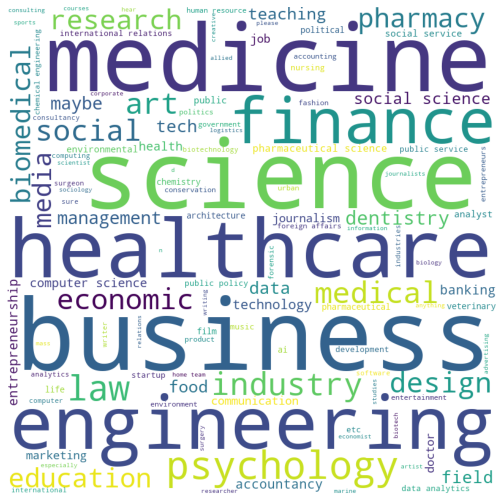

In [225]:
stopwords = set(STOPWORDS).union(set(['','1', '2','sector', 'related', 'sectors', 'careers', 'profession', 'work']))

next_wc = WordCloud(width=800, height=800, background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(next_combined_string)
plt.figure(figsize = (16,9))
plt.imshow(next_wc)
plt.axis('off')
# plt.savefig('wordcloud.png')